# Corrosion
## Input
+ raw 
moisture

temperature

<-chloride and carbonation from other modules

+ external helping module
TDR -> moisture
temperature from database

## Output
icorr/sectionloss with time

accumulated/ integral of icorr with time


In [9]:
%matplotlib notebook

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import stats
import numpy as np
from helper_func import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# model function
# def icorr_f(carbonation, chloride, moisture_theta):
    
#     icorr1?
#     icorr2?
#     icorr3?
#     icorr4?
    
#     return icorr_list

def icorr_to_mmpy(icorr):
    """icorr(A/m^2) to mm/year"""
    M_Fe = 55.8e-3 #kg/mol
    rho_Fe = 7.874e3 # kg/m^3
    n=2.

    F=96485.33212 #C mol^−1
    return icorr*M_Fe/(n*F*rho_Fe)*3600*24*365*1000.

def mmpy_to_icorr(rate):
    """mm/year to icorr(A/m^2)"""
    M_Fe = 55.8e-3 #kg/mol
    rho_Fe = 7.874e3 # kg/m^3
    n=2.
    F=96485.33212 #C mol^−1
    return rate*n*F*rho_Fe/(M_Fe*3600*24*365*1000.)
    
def icorr_base(rho, T, iL, d): # SI units # regressed model for the ref
    """ calculate averaged corrosion current density over the rebar-concrete surface from resistivity, temperature, limiting current and cover thickness
    Parameters
    ----------
    rho : resistivity [ohm.m]
    T : temperature [K]
    iL : limiting current, oxygen diffusion [ A/m^2]
    d : concrete cover depth [m]
    
    Returns
    -------
    icorr : corrosion current density, treated as uniform corrosion [A/m^2]
    Notes
    -----
    reference: Pour-Ghaz, M., Isgor, O. B., & Ghods, P. (2009)The effect of temperature on the corrosion of steel in concrete. Part 1: Simulated polarization resistance tests and model development. Corrosion Science, 51(2), 415–425. https://doi.org/10.1016/j.corsci.2008.10.034
    parameters from ref
    SI units
    """
    # constants
    tau = 1.181102362e-3 
    eta = 1.414736274e-5 
    c = -0.00121155206 
    kappa = 0.0847693074 
    lam = 0.130025167 
    gamma = 0.800505851
    mu = 1.23199829e-11
    theta = -0.000102886027
    V = 0.475258097
    X = 5.03368481e-7
    nu = 90487
    W = 0.0721605536
    
    icorr = 1/(tau*rho**gamma)*(eta*T*d**kappa*iL**lam + mu*T*nu**(iL**W) + theta*(T*iL)**V + X*rho**gamma + c)
    return icorr

def theta2rho_fun(theta_water,a,b):
    """volumetric water content to resistivity, index fun used"""
    rho = a*theta_water**b
    return rho


def icorr_f(pars): 
    ''' A wrapper of the icorr_base() with modified parameters (resistivity rho->volumetric water content, theta_water)
    by theta2rho_fun().
    
    Parameters
    ----------
    pars : parameter class
            pars.theta_water, 
            pars.T, 
            pars.iL, 
            pars.d, 
            pars.a, 
            pars.b
    
    Returns
    -------
    icorr : corrosion current density [A/m^2]
    '''
    # previously calibrated to carbonated concrete
    pars.iL = iL_f(pars)
    icorr = icorr_base(theta2rho_fun(pars.theta_water, pars.theta2rho_coeff_a, pars.theta2rho_coeff_b), 
                        pars.T , pars.iL , pars.d )
    return icorr

def iL_f(pars):
    """calculate O2 limiting current density 
    Parameters
    ----------
    pars : object
    Notes
    -----
    z : number of charge, 4 for oxygen
    D : diffusivity [m^2/s]
    Cs : bulk concentration [mol/m^3]
    delta : thickness of diffusion layer [m]
    pars.epsilon_g : gas phase fraction
    
    returns
    -------
    iL : current density over the steel concrete interface [A/m^2]
    """
    F = 96485.3329  # s*A/mol
    z = 4
    
    pars.De_O2 = De_O2_f(pars)  # effective diffusivity averaged for the whole concrete medium
    delta = pars.d
    pars.Cs_g = Cs_g_f()
    pars.epsilon_g = pars.epsilon - pars.theta_water

    # assume quick dissolution between gas and liquid phase 
    # liquid phase diffusion is neglected[TODO], very slow iL = 0 when epsilon_g = 0
    
    iL = z * F * (pars.epsilon_g * pars.De_O2 * pars.Cs_g / delta)  # pars.epsilon_g * pars.Cs is the concentration of concrte
    return iL

def Cs_g_f():
    """O2 concentration in gas phase on the boundary [mol/m^3]"""
    O2_fraction = 20.95/100
    air_molar_vol = 22.4 # [L/mol]
    Cs_g =  1 /air_molar_vol * O2_fraction * 1000  # mol/m^3
    return Cs_g



def De_O2_f(pars):
    """O2 effective diffusivity [TODO: add temperature dependence]
    Parameters
    ----------
    pars : object
    
    Notes
    -----
    epsilon_p : porosity of hardened cement paste,
    RH : relative humidity [-%]

    because diffusion along the aggregate-paste interface makes up for the lack of diffusion through the aggregate particles themselves. 
    Therefore, the value of effective diffusivity is considered herein as a function of the porosity of hardened ce- ment paste
    """
    epsilon_p = epsilon_p_f(pars)
    pars.epsilon_p = epsilon_p
    
    # calcualte internal RH with retension curve/ adsoption curve
    WaterbyMassHCP = theta_water_to_WaterbyMassHCP(pars) # water content g/g hardened cement paste
    pars.WaterbyMassHCP = WaterbyMassHCP 
    
    RH = WaterbyMassHCP_to_RH(pars)
    pars.RH = RH
    
    #[TODO] D_O2_T0 * np.e**(dU_D/R*(1/T0-1/T)) Pour-Ghaz, M., Burkan Isgor, O., & Ghods, P. (2009). The effect of temperature on the corrosion of steel in concrete. Part 2: Model verification and parametric study. Corrosion Science, 51(2), 426–433. https://doi.org/10.1016/j.corsci.2008.10.036
    De_O2 = 1.92e-6 * epsilon_p**1.8 * (1-RH/100)**2.2
    return De_O2

def epsilon_p_f(pars):
    """calculate the porosity of the hardened cement paste from the concrete porosity"""    
    try:
        if isinstance(int(pars.epsilon),int):  # concrete porosity, epsilon is given
            a_c = pars.a_c # aggregate cement ratio
            w_c = pars.w_c # water cement ratio
            rho_c = pars.rho_c   # density of cement
            rho_a = pars.rho_a   # density of aggregate
            rho_w = 1000.
            epsilon_p = pars.epsilon * (1 + (a_c*rho_c/rho_a)/(1+ w_c*rho_c/rho_w))
        else:
            # use calculation
            
            pass #[TODO: epsilon is time dependent, a function of concrete mix and t]
    except:
        print('cement paste porosity, epsilon_p is not configured!')
        
    return epsilon_p


def calibrate_f(raw_model, field_data):  # [TODO]
    """field_data: temperature, theta_water, icorr_list"""
    model = raw_model.copy()
    return model

In [11]:
# RH and water theta is related!!!! use theretical model adsorption isotherm or Van-Genutchten model
def RH_to_WaterbyMassHCP(pars):
    """return water content(g/g hardended cement paste) from RH in pores/environment based on w_c, cement_type, Temperature
    
    Notes
    -----
    Ref:Xi, Y., Bazant, Z. P., & Jennings, H. M. (1993). Moisture Diffusion in Cementitious Materials Adsorption Isotherms.
    """
    V_m = V_m_f(pars.t, pars.w_c, pars.cement_type)
    pars.V_m = V_m
    
    C_mean, C = C_f(pars.T) # mean, distribution sample
    pars.C = C
    
    k = k_f(pars.T, C_mean, pars.w_c, pars.t, pars.cement_type)
    pars.k = k
    
    RH_devided_by_100 = pars.RH/100
    
    WaterbyMassHCP = V_m * C * k * RH_devided_by_100 /( (1-k*RH_devided_by_100)*(1+ (C-1)*k*RH_devided_by_100) )
    
    return WaterbyMassHCP



def WaterbyMassHCP_to_RH(pars):
    """return RH in pores/environment from water content(g/g hardened cement paste) based on w_c, cement_type, Temperature
    a reverse function of RH_to_WaterbyMassHCP()"""
    V_m = V_m_f(pars.t, pars.w_c, pars.cement_type)
    pars.V_m = V_m
    
    C_mean, C = C_f(pars.T) # mean, distribution sample
    pars.C = C
    
    k = k_f(pars.T, C_mean, pars.w_c, pars.t, pars.cement_type)
    pars.k = k
    
    WaterbyMassHCP = pars.WaterbyMassHCP

    r1,r2 = f_solve_poly2(-(C-1)*k**2 , (C-2-C*V_m/WaterbyMassHCP)*k, 1)
    
    if r1.mean()>0:
        RH_devided_by_100 = r1    
    else:
        RH_devided_by_100 = r2
        
    RH = RH_devided_by_100 * 100
    return RH


def V_m_f(t, w_c, cement_type):
    """ Calcuate V_m, a BET model parameter
    
    Parameters
    ----------
    t : curing time/concrete age [day]
    w_c : water-cement ratio 
    
    Returns
    -------
    V_m : BET model parameter
    
    Notes
    -----
    ASTM C150 describes: 
    Cement Type          Description
    Type I               Normal
    Type II              Moderate Sulfate Resistance
    Type II (MH)         Moderate Heat of Hydration (and Moderate Sulfate Resistance)                            
    Type III             High Early Strength
    Type IV              Low Heat Hydration
    Type V               High Sulfate Resistance
    """
    if t < 5:
        t = 5
        
    if w_c < 0.3:
        w_c = 0.3
    if w_c > 0.7:
        w_c = 0.7
    
    V_ct_cement_type_dict = {'Type I':0.9,'Type II':1, 'Type III':0.85, 'Type IV' : 0.6}
    V_ct = V_ct_cement_type_dict.get(cement_type,0.9)  # default value is 0.9, returns default when type is not found
    
    V_m_mean = (0.068 - 0.22/t) * (0.85 + 0.45* w_c) * V_ct
    V_m_std = 0.016 * V_m_mean # COV
    V_m = Normal_custom(V_m_mean, V_m_std)
    return V_m

def C_f(T):
    """ returns BET model paramter C, which varies from 10 to 50, not applicable for high temperatures"""
    C_0 = 855
    C_mean=np.e**(C_0/T)
    C_std = C_mean * 0.12  # COV 0.12
    C = Normal_custom(C_mean, C_std)
    return C_mean, C
    
def k_f(T, C_mean, w_c, t, cement_type):
    """ returns BET model parameter k"""
    if t < 5:
        t = 5
        
    if w_c < 0.3:
        w_c = 0.3
    if w_c > 0.7:
        w_c = 0.7

    N_ct_cement_type_dict = {'Type I':1.1,'Type II':1, 'Type III':1.15, 'Type IV' : 1.5}
    N_ct = N_ct_cement_type_dict.get(cement_type,1.1)  # default value is 1.1, returns default when type is not found
    
    n = (2.5 + 15/t) * (0.33 +2.2* w_c) * N_ct
    
    k_mean = ((1-1/n)*C_mean - 1) / (C_mean-1)
    k_std = k_mean*0.007
    k = Normal_custom(k_mean, k_std)
    return k

In [12]:
# convert theta_water to W or W to theta_water

def WaterbyMassHCP_to_theta_water(pars):
    """g/g HCP to volumetric by HCP to volumetric by concrete"""
    rho_w = 1000
    WaterbyMassHCP = pars.WaterbyMassHCP
    
    rho_c = pars.rho_c
    rho_a = pars.rho_a
    a_c = pars.a_c
    w_c = pars.w_c
    theta_water_hcp = 1 / ( 1+( 1/WaterbyMassHCP -1 ) * rho_w/rho_c)
    
    theta_water = theta_water_hcp / (1 + (a_c*rho_c/rho_a)/(1+ w_c*rho_c/rho_w))
    return theta_water

def theta_water_to_WaterbyMassHCP(pars):
    """ volumetric by concrete to volumetric by HCP  to g/g HCP  
    a reverse function of WaterbyMassHCP_to_theta_water()"""
    rho_w = 1000
    theta_water = pars.theta_water
    rho_c = pars.rho_c
    rho_a = pars.rho_a
    a_c = pars.a_c
    w_c = pars.w_c
    
    theta_water_hcp = theta_water * (1 + (a_c*rho_c/rho_a)/(1+ w_c*rho_c/rho_w))
    WaterbyMassHCP = 1 / ((1/theta_water_hcp - 1)*rho_c/rho_w +1)
    return WaterbyMassHCP

In [13]:
class Corrosion_Model:
    def __init__(self, pars):
        # default
        pars.theta2rho_coeff_a = 18.71810174 # [TODO: uncertainty for a and b]
        pars.theta2rho_coeff_b = -1.37938931
        self.pars = pars
        
    def run(self):
        self.icorr = icorr_f(self.pars)
        self.x_loss = icorr_to_mmpy(self.icorr)  # [mm/year]
        
    def calibrate(self,field_data):
        # update parameters a and b
        pass
    
    def copy(self):
        return deepcopy(self)

# Case study

In [14]:
class Param: pass
raw_pars = Param()

# geometry
raw_pars.d = 0.04 # cover depth [m]
raw_pars.t = 3650 # [day]!!!
raw_pars.cement_type = 'Type I'
raw_pars.concrete_density = 2400 #kg/m^3

# concrete condition
raw_pars.epsilon = 0.25  # porosity of concrete [TODO a function of time]
raw_pars.theta_water = 0.12#Beta_custom(0.10,0.01,pars.epsilon,0)
raw_pars.T = 273.15+25

# concrete composition
raw_pars.a_c = 2  # aggregate(find and coarse)/cement ratio
raw_pars.w_c = 0.5  # water/cement ratio
raw_pars.rho_c= 3.1e3  # density of cement particle
raw_pars.rho_a= 2600. # density of aggregate particle(fine and coarse) range 2400-2900 



In [15]:
M = Corrosion_Model(raw_pars)
M.run()
M.icorr

array([0.04045711, 0.03924961, 0.03359764, ..., 0.04077909, 0.03283991,
       0.04056233])

<IPython.core.display.Javascript object>


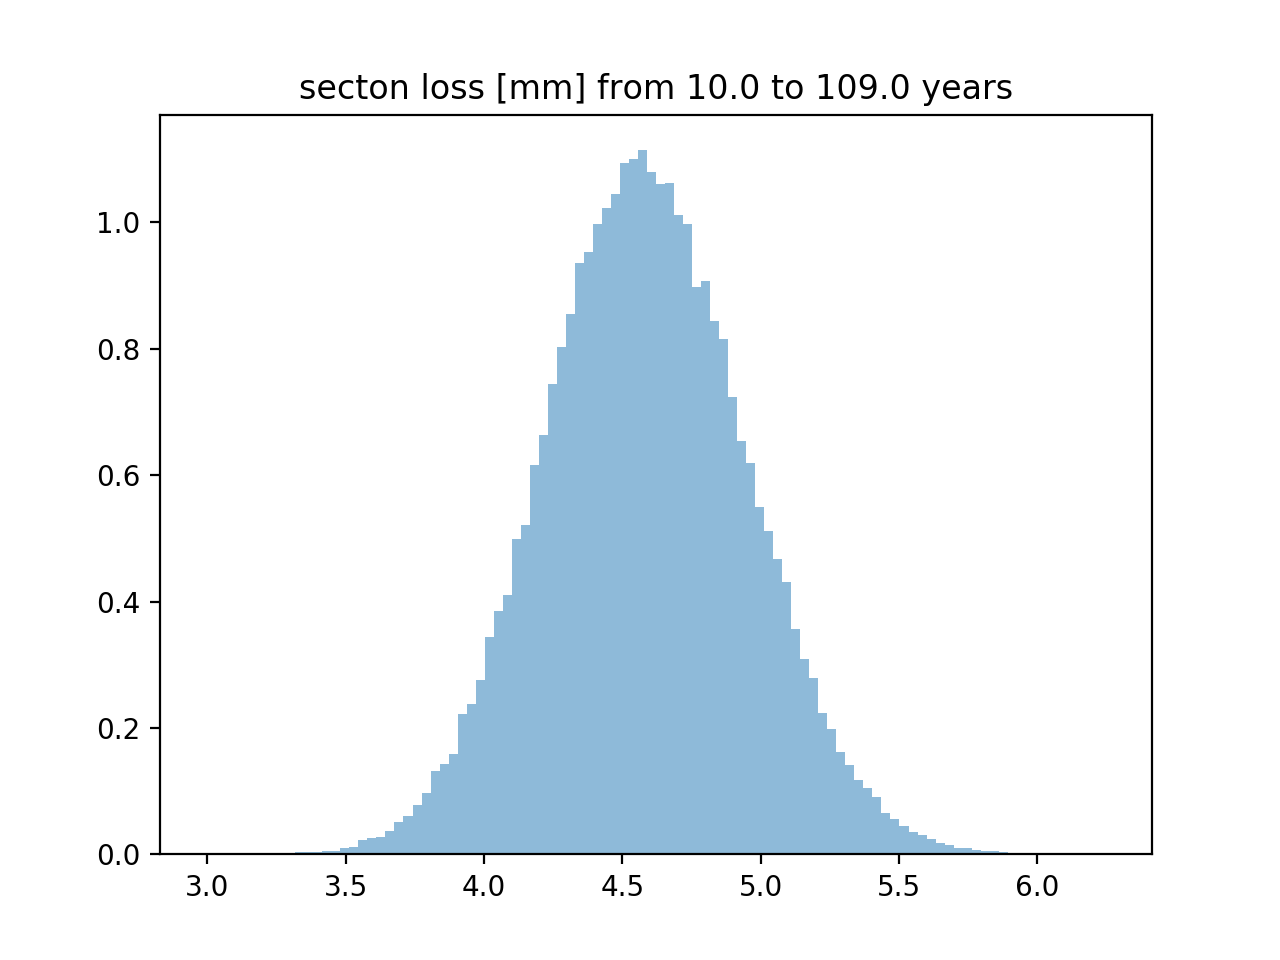

Text(0.5, 1.0, 'secton loss [mm] from 10.0 to 109.0 years')

In [16]:
# Accumulated section loss
t_lis = np.arange(3650, 36500 + 3650 , 3650/10)  
M_lis = []
model = M.copy()
for this_t in t_lis:
    model.pars.t = this_t
    model.run()
    M_lis.append(model)

section_loss_t = np.array([this_M.x_loss for this_M in M_lis])
Hist_custom(sample_integral(section_loss_t,t_lis/365))  # section loss [mm/year] t_lis [day]
plt.title('section loss [mm] from {} to {} years'.format((t_lis/365).min(),(t_lis/365).max()))

# construction zone

In [95]:
# Calibrate

theta_water_input = np.linspace(0.05,0.30,20)
T = np.linspace(-40,40,20)
x1 = theta_water_input
y1 = T

nx, ny = 30, 30
xx, yy = np.meshgrid(np.linspace(x1.min(), x1.max(), nx), 
                     np.linspace(y1.min(), y1.max(), ny))

zz = icorr_f(xx,yy, 2.4,4e-2)  # [TODO] icorr_f(pars), iterate through all xx and yy

# Plot
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

surf = ax.plot_surface(xx, yy-273.15, zz*100,alpha=1,cmap='gray',linewidth=0)
fig.colorbar(surf,shrink=0.5)

# ax.scatter(theta_water, np.ones(theta_water.size)*25, theta_water*5.24,
#            c=theta_water*5.24,cmap='gray',marker='.',s=100,
#            alpha = 1,
#         label=r'Room temp model $i_{corr}=5.25\cdot {\theta}_w [\mu A/cm^2]$')


ax.set_xlabel('Volumetric water content')
ax.set_ylabel(u'Temperature (℃)')

ax.set_zlabel('icorr$[\mu A/cm^2]$')
plt.tight_layout()



TypeError: icorr_f() takes 1 positional argument but 4 were given